# Imports

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import git
repo = git.Repo("./", search_parent_directories=True)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Constructing model

Let us first try the simpler SIR case:

## SIR

In [20]:
ensemble = []

In [40]:
import math
import random

# Input parameters ####################

# int; total population
N = 350

# float; maximum elapsed time
T = 100.0

# float; start time
t = 0.0

# float; spatial parameter
V = 100.0

# float; rate of infection after contact
_alpha = 10.0

# float; rate of cure
_beta = 0.5

# int; initial infected population
n_I = 1

#########################################

# Compute susceptible population, set recovered to zero
n_S = N - n_I
n_R = 0

# Initialize results list
SIR_data = []
SIR_data.append((t, n_S, n_I, n_R))

# Main loop
while t < T:
    if n_I == 0:
        break

    w1 = _alpha * n_S * n_I / V
    w2 = _beta * n_I
    W = w1 + w2

    dt = -math.log(random.uniform(0.0, 1.0)) / W
    t = t + dt

    if random.uniform(0.0, 1.0) < w1 / W:
        n_S = n_S - 1
        n_I = n_I + 1
    else:
        n_I = n_I - 1
        n_R = n_R + 1

    SIR_data.append((t, n_S, n_I, n_R))
ensemble.append(SIR_data)

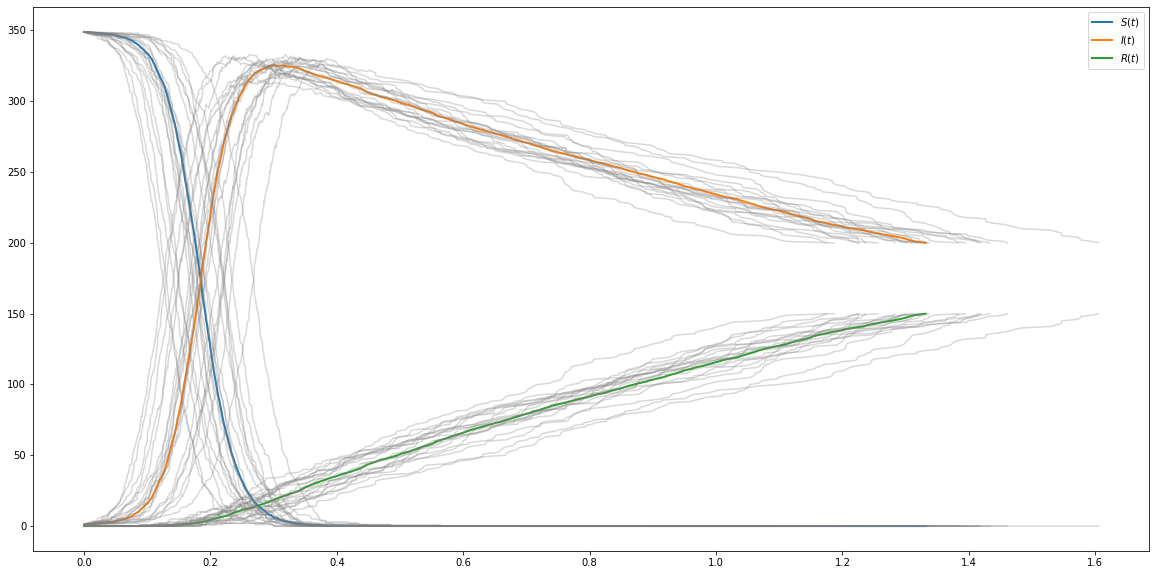

In [60]:
t_max = 500
data = np.array(ensemble)
m = np.mean(np.array(ensemble),axis=0)
plt.figure(figsize=(20,10))
plt.plot(m[:t_max,0],m[:t_max,1:], lw=2)
plt.legend([r"$S(t)$",r"$I(t)$",r"$R(t)$"])
for k in range(20):
    plt.plot(data[k,:t_max,0],data[k,:t_max,1:], alpha=0.3, c='gray')
plt.show()

## SEIR-QD with parameters solved from least_squares

In [51]:
import math
import random
def sim(N, T, params, initial_conditions, initial_death=0):
    # Input parameters ####################

    # float; start time
    t = 0.0

    _beta = params[0]
    _delta = params[1]
    _gamma = params[2]
    _alpha = params[3]
    _lambda = params[4]
    _kappa = params[5]

    # int; initial infected population
    n_e = initial_conditions[0]
    n_i = initial_conditions[1]
    n_q = initial_conditions[2]
    n_r = initial_conditions[3]
    n_sa = initial_conditions[4]
    
    n_d = initial_death
    n_s = N - np.sum(initial_conditions) - n_d

    # Initialize results list
    SIR_data = []
    current = np.array([0.0, n_s, n_e, n_i, n_r, n_q, n_d, n_sa])
    SIR_data.append(current.copy())
    # Main loop
    while current[0] < T:
        
        ws = np.concatenate((np.array([_beta * current[1] * current[3] / N]),
                             np.array([_alpha,_gamma,_lambda,_kappa,_delta])*current[[1,2,3,5,5]])
                           )
        ws_cum = np.cumsum(ws)
        dt = -math.log(random.uniform(0.0, 1.0)) / ws_cum[-1]
        current[0] += dt
        u = random.uniform(0.0, 1.0)
        if u < ws_cum[0] / ws_cum[-1]:
            current[1] -= 1
            current[2] += 1
        elif u < ws_cum[1]/ws_cum[-1]:
            current[1] -= 1
            current[7] += 1
        elif u < ws_cum[2]/ws_cum[-1]:
            current[2] -= 1
            current[3] += 1
        elif u < ws_cum[3]/ws_cum[-1]:
            current[3] -= 1
            current[5] += 1
        elif u < ws_cum[4]/ws_cum[-1]:
            current[5] -= 1
            current[6] += 1
        else:
            current[5] -= 1
            current[4] += 1
        SIR_data.append(current.copy())
    return SIR_data

In [64]:
result = sim(10000, 100, [1.319399 ,0.375707 ,0.543432 ,0.080759 ,0.006279 ,0.421636], np.array([5, 5, 2, 0, 5000]))

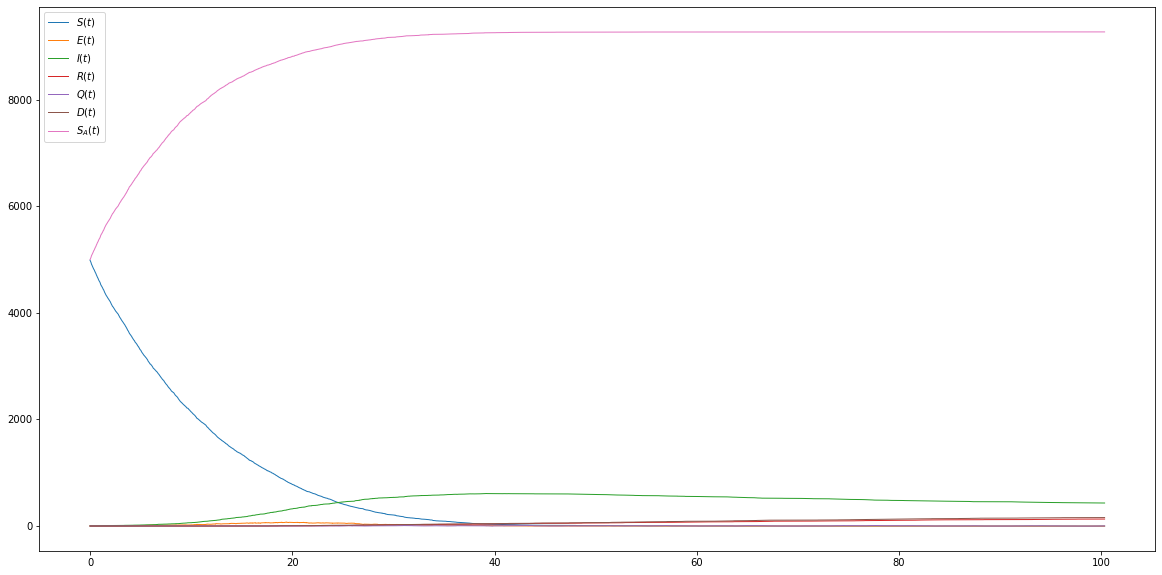

In [53]:
data = np.array(result)
plt.figure(figsize=(20,10))
plt.plot(data[:,0],data[:,1:], lw=1)
plt.legend([r"$S(t)$",r"$E(t)$",r"$I(t)$",r"$R(t)$",r"$Q(t)$",r"$D(t)$",r"$S_A(t)$"])

In [69]:
np.array(result)[:,[0,6]]

array([[0.00000000e+00, 0.00000000e+00],
       [1.25895358e-03, 0.00000000e+00],
       [8.33041967e-03, 0.00000000e+00],
       ...,
       [9.95851174e+01, 1.63000000e+02],
       [9.97464143e+01, 1.63000000e+02],
       [1.00023514e+02, 1.63000000e+02]])

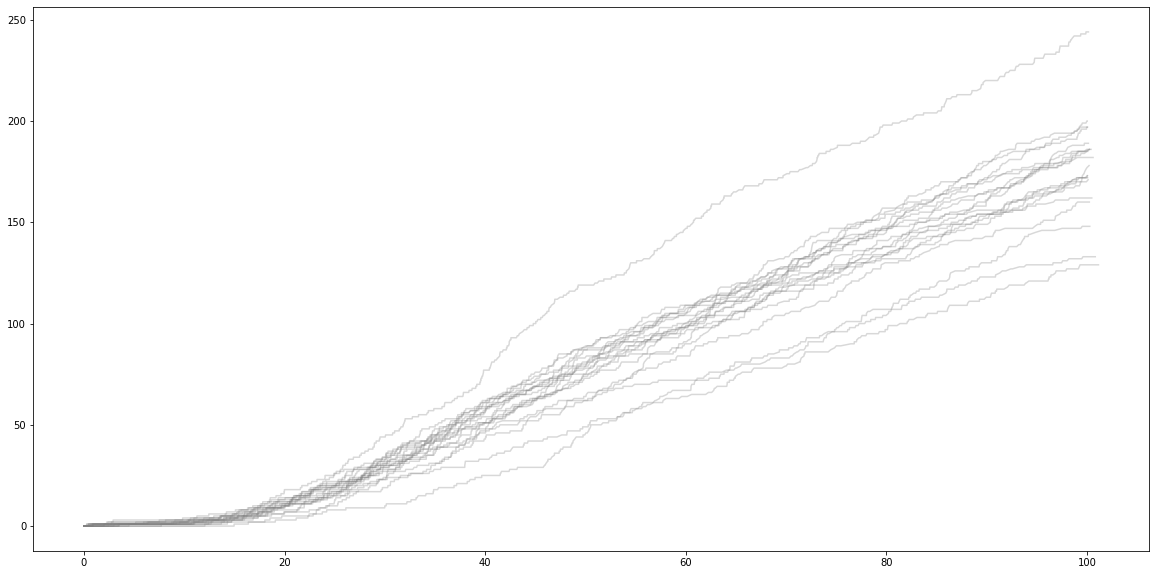

In [76]:
plt.figure(figsize=(20,10))
for k in range(20):
    data = np.array(sim(10000, 100, [1.319399 ,0.375707 ,0.543432 ,0.080759 ,0.006279 ,0.421636], np.array([5, 5, 2, 0, 5000])))[:,[0,6]]
    plt.plot(data[:,0],data[:,1], alpha=0.3, c='gray')    
plt.show()

In [73]:
def diff(dat, t,params):
    beta = params[0]
    delta = params[1]
    gamma = params[2]
    alpha = params[3]
    lambda_ = params[4]
    kappa = params[5]
    
    s = dat[0]
    e = dat[1]
    i = dat[2]
    q = dat[3]
    r = dat[4]
    d = dat[5]
    sa = dat[6]
    
    dsdt = - beta * s * i - alpha * s
    dedt = beta * s * i - gamma * e
    didt = gamma * e - lambda_ * i
    dqdt = lambda_ * i - delta * q - kappa * q
    drdt = delta * q
    dddt = kappa * q
    dsadt = alpha * s
    
    # susceptible, exposed, infected, quarantined, recovered, died, unsusceptible
    return [dsdt, dedt, didt, dqdt, drdt, dddt, dsadt]
from scipy.integrate import odeint
def model(params, tmax, initial_death=0):
    # initial conditions
    initial_conditions = np.array(params[-5:]) # the parameters are a fraction of the population so multiply by the population
    
    # initial conditions
    e0 = initial_conditions[0]
    i0 = initial_conditions[1]
    q0 = initial_conditions[2]
    r0 = initial_conditions[3]
    sa0 = initial_conditions[4]
    
    d0 = initial_death
    s0 = 1 - np.sum(initial_conditions) - d0

    yz_0 = np.array([s0, e0, i0, q0, r0, d0, sa0])
    
    # Package parameters into a tuple
    args = (params,)
    
    
    # Integrate ODEs
    s = odeint(diff, yz_0, np.arange(0, tmax), args=args)

    return s
def death_cost(params, Ddata, Idata):
    s = model(params, tmax=len(Ddata))
    D = s[:,5]
    I = s[:,2]
    error = np.concatenate((D-Ddata, I - Idata))
    return error

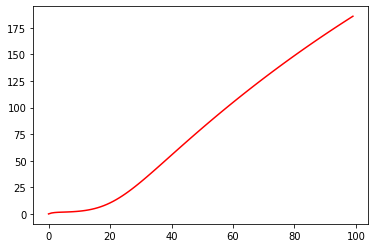

In [79]:
death_ode = model([1.319399 ,0.375707 ,0.543432 ,0.080759 ,0.006279 ,0.421636, 0.5e-3, 0.5e-3, 0.3e-3, 0.1e-4, 0.5], 100, initial_death=0)[:,5]*10000
plt.plot(death_ode, c='r')

In [ ]:
t_max = 500
data = np.array(ensemble)
m = np.mean(np.array(ensemble),axis=0)
plt.figure(figsize=(20,10))
plt.plot(m[:t_max,0],m[:t_max,1:], lw=2)
plt.legend([r"$S(t)$",r"$I(t)$",r"$R(t)$"])
for k in range(20):
    plt.plot(data[k,:t_max,0],data[k,:t_max,1:], alpha=0.3, c='gray')
plt.show()